In [1]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
players = pd.read_csv("../processed_data/clean/players.csv",index_col = 0)
players.head()

,height,weight,birthDate,collegeName,position,displayName
nflId,,,,,,
2539334,1.83,86,1990-09-10,Washington,CB,Desmond Trufant
2539653,1.78,84,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2543850,1.75,84,1991-12-18,Purdue,SS,Ricardo Allen
2555162,1.85,103,1994-11-04,Louisiana State,MLB,Deion Jones
2555255,1.91,105,1993-07-01,Minnesota,OLB,De'Vondre Campbell


In [4]:
summary = pd.read_csv("summary.csv",index_col=0)
summary

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,71251.0,2018093006:2225:4,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
1,89756.0,2018093006:2225:4,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
2,494287.0,2018093006:2225:4,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
4,2541243.0,2018093006:2225:4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2550164.0,2018120902:699:14,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
753,2552389.0,2018120902:699:14,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
754,2555166.0,2018120902:699:14,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1
755,2555540.0,2018120902:699:14,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1


In [5]:
len(summary[summary["defenseValoration"]==0])/len(summary)

0.44596912521440824

In [6]:
len(summary[summary["defenseValoration"]==1])/len(summary)

0.5540308747855918

# Cambiar valor gameClock

In [7]:
from datetime import datetime
s1 = "15:00:00"
s2 = "03:29:00"
format = "%M:%S:%f"
time = datetime.strptime(s1, format) - datetime.strptime(s2, format)
print(time.total_seconds())
print(str(time).split(":"))

691.0
['0', '11', '31']


In [8]:
def changeGameClock(value,quarter):
    if quarter == 1:
        total_time = 3600
    elif quarter == 2:
        total_time = 2700
    elif quarter == 3:
        total_time = 1800
    elif quarter == 4:
        total_time = 900
    
    format = "%M:%S:%f"
    actual_time = datetime.strptime(value, format) - datetime.strptime("00:00:00",format)
    time = total_time - (900 - actual_time.total_seconds())
    return time

In [9]:
changeGameClock("00:07:00",2)

1807.0

In [10]:
summary_cp = summary.copy()

In [11]:
summary_cp["gameClock"] = summary_cp.apply(lambda x: changeGameClock(x["gameClock"],x["quarter"]),axis=1)

In [12]:
summary_cp.drop(["playerId","playId"],axis=1,inplace=True)

In [13]:
summary_cp

,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
1,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
2,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
3,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
753,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
754,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1
755,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,2909.0,1


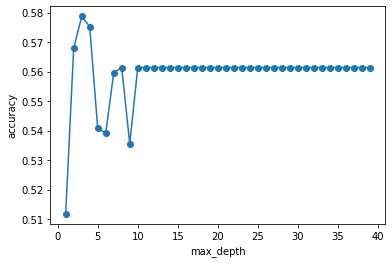

In [14]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(summary_cp))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:5.5,1:4.4}
                                            )
    for train_fold, test_fold in cv.split(summary_cp):
        f_train = summary_cp.iloc[train_fold]
        f_test = summary_cp.iloc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['defenseValoration'], axis=1), 
                               y = f_train['defenseValoration'])
        test_acc = model.score(X = f_test.drop(['defenseValoration'], axis=1), 
                                y = f_test['defenseValoration'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.3)

In [16]:
from sklearn.model_selection import GridSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25],'min_samples_split':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
             'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],'splitter':["best","random"],
              'class_weight':[{0:5.5,1:4.4},{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:2}]}
tree_model = tree.DecisionTreeClassifier()
clf = GridSearchCV(tree_model, tree_param)

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
clf.best_params_

Hacerlo con randomSearch tambien

In [20]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 10)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 1.0


In [21]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split = 65, 
                                  min_samples_leaf = 20, max_depth = 10, 
                                  class_weight={0:5.5,1:4.4})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8285714285714286


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.85135135 0.14864865]
 [0.18811881 0.81188119]]


TypeError: 'str' object is not callable

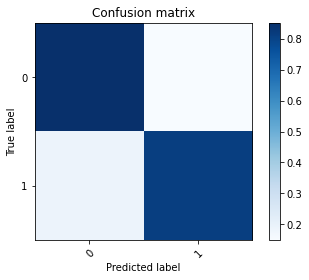

In [23]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

In [19]:
summary_cp.head()

,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
0,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
1,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
2,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
3,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0
4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,1807.0,0


In [20]:
predict_proba = regressor.predict_proba(summary_cp.drop(["defenseValoration"],axis=1))[:,1]

In [21]:
summary["predict_proba"] = predict_proba
summary

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
0,71251.0,2018093006:2225:4,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.713376
1,89756.0,2018093006:2225:4,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.713376
2,494287.0,2018093006:2225:4,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.713376
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.713376
4,2541243.0,2018093006:2225:4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.713376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2550164.0,2018120902:699:14,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.876033
753,2552389.0,2018120902:699:14,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.876033
754,2555166.0,2018120902:699:14,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.876033
755,2555540.0,2018120902:699:14,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.876033


In [24]:
predict_proba_sums = summary.groupby("playerId")["predict_proba"].sum()
predict_proba_sums

playerId
1302.0       1.112150
2307.0       0.403670
2354.0       1.589409
4365.0       1.380775
71251.0      1.544836
               ...   
2561042.0    0.876033
2561117.0    0.403670
2561132.0    0.876033
2561318.0    0.000000
2561644.0    1.000000
Name: predict_proba, Length: 284, dtype: float64

In [45]:
players.loc[2558183]

height                   1.83
weight                     95
birthDate          1995-12-19
collegeName    Boston College
position                   SS
displayName      John Johnson
Name: 2558183, dtype: object

In [24]:
summary[summary["playerId"]==2533062]

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.000000,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0
38,2533062.0,2018111108:1321:10,1.681338,1.068655,1.000000,1.000000,51.71845,1,1,4,0.096677,1.32,-24.46,0.0,17.0,10.0,3,2,5,70.0,12:12:00,1
271,2533062.0,2018112505:994:12,6.896196,3.954111,0.230769,0.625000,-57.18130,0,0,4,-0.069953,-2.31,-16.03,0.0,7.0,7.0,3,2,3,52.0,14:15:00,1
284,2533062.0,2018110410:4090:9,4.040905,2.469223,0.944444,1.833333,-31.99280,0,0,7,-0.218799,-2.11,-28.13,0.0,31.0,17.0,3,4,8,72.0,05:24:00,0


In [43]:
for player in predict_proba_sums.index:
    print(player,players.loc[player]["displayName"])

1302.0 Aqib Talib
2307.0 Orlando Scandrick
2354.0 Wesley Woodyard
4365.0 Brandon Carr
71251.0 Patrick Chung
71441.0 Glover Quin
79848.0 Malcolm Jenkins
80668.0 Captain Munnerlyn
89756.0 Jason McCourty
238227.0 Mike Mitchell
494259.0 Barry Church
494277.0 Kendrick Lewis
494287.0 Devin McCourty
494289.0 Sherrick McManis
494307.0 Darian Stewart
496733.0 Joe Haden
496735.0 Kareem Jackson
496739.0 Reshad Jones
1037374.0 Sam Shields
2495108.0 Prince Amukamara
2495153.0 Marcus Gilchrist
2495281.0 Mason Foster
2495343.0 Buster Skrine
2495504.0 Patrick Peterson
2495507.0 Richard Sherman
2495613.0 Corey Graham
2495617.0 Leon Hall
2495775.0 Eric Weddle
2495807.0 Antoine Bethea
2495872.0 Johnathan Joseph
2505660.0 Terrell Suggs
2505708.0 Mike Adams
2506345.0 Adam Jones
2506352.0 Thomas Davis
2506789.0 Tramon Williams
2507167.0 Reggie Nelson
2507843.0 Vincent Rey
2507917.0 Tramaine Brock
2508004.0 Anthony Levine
2508084.0 Patrick Robinson
2508107.0 Jimmy Smith
2525323.0 Andrew Sendejo
2530491.0 Jos

In [39]:
valoration_players = {}
for player in predict_proba_sums.index:
    valoration_players[players.loc[player]["displayName"]] = predict_proba_sums[player]

In [42]:
dict(sorted(valoration_players.items(), key=lambda item: item[1]))

{'Barry Church': 0.0,
 'Joe Haden': 0.0,
 'Corey Graham': 0.0,
 'Vincent Rey': 0.0,
 'Coty Sensabaugh': 0.0,
 'Vontaze Burfict': 0.0,
 'Keith Tandy': 0.0,
 'Avery Williamson': 0.0,
 'Terrence Brooks': 0.0,
 'Kareem Martin': 0.0,
 'Preston Brown': 0.0,
 'Ricardo Allen': 0.0,
 'Vic Beasley': 0.0,
 'Jordan Richards': 0.0,
 'Artie Burns': 0.0,
 'Clayton Fejedelem': 0.0,
 'Sean Davis': 0.0,
 'Mike Hilton': 0.0,
 'Patrick Onwuasor': 0.0,
 'Sidney Jones': 0.0,
 'T.J. Watt': 0.0,
 'Cameron Sutton': 0.0,
 'Adrian Colbert': 0.0,
 'Terrell Edmunds': 0.0,
 'Marcus Allen': 0.0,
 'Tae Davis': 0.0,
 'Deone Bucannon': 0.11214953271028036,
 "Za'Darius Smith": 0.11214953271028036,
 'Budda Baker': 0.11214953271028036,
 'Chuck Clark': 0.11214953271028036,
 'Kenny Young': 0.11214953271028036,
 'A.J. Klein': 0.22429906542056072,
 'Malcolm Jenkins': 0.2804428044280443,
 'Mike Mitchell': 0.2804428044280443,
 'Leon Hall': 0.2804428044280443,
 'Terrell Suggs': 0.2804428044280443,
 'Nigel Bradham': 0.28044280442

In [41]:
summary[summary["playerId"]==1302]

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
142,1302.0,2018091001:939:1,9.746685,9.025017,0.0,0.000000,24.6485,1,1,6,0.283993,-0.69,-27.61,0.0,7.0,7.0,3,1,10,59.0,00:34:00,0,0.81203
305,1302.0,2018122311:2290:16,9.388013,6.177330,0.0,0.315789,116.1359,2,1,5,0.060274,5.24,-17.40,0.0,9.0,21.0,3,3,9,45.0,12:05:00,1,1.00000


Valor = predict_proba - (1- predict_proba)

In [46]:
summary["predict_proba"] = predict_proba - (1 - predict_proba)
summary

,playerId,playId,meanDistance,meanDistanceAfterPass,numberPlayers5yds,numberPlayers5ydsAfterPass,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
0,71251.0,2018093006:2225:4,10.568907,11.791571,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.426752
1,89756.0,2018093006:2225:4,10.946105,4.581272,0.264706,0.8,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.426752
2,494287.0,2018093006:2225:4,31.074778,19.611594,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.426752
3,2533062.0,2018093006:2225:4,22.644911,19.288428,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.426752
4,2541243.0,2018093006:2225:4,24.893454,14.407899,0.000000,0.0,44.67445,5,0,3,0.179073,5.27,-41.73,2.0,24.0,0.0,3,2,1,66.0,00:07:00,0,0.426752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,2550164.0,2018120902:699:14,8.330134,4.746337,0.148148,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.752066
753,2552389.0,2018120902:699:14,17.275020,3.427559,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.752066
754,2555166.0,2018120902:699:14,10.335948,4.058543,0.000000,0.7,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.752066
755,2555540.0,2018120902:699:14,15.836416,8.746987,0.000000,0.0,-172.00910,5,4,2,-0.040696,-10.46,-55.60,0.0,7.0,7.0,3,1,21,63.0,03:29:00,1,0.752066


In [47]:
predict_proba_sums = summary.groupby("playerId")["predict_proba"].sum()
predict_proba_sums

playerId
1302.0       0.224299
2307.0      -0.192661
2354.0       1.178818
4365.0      -2.238450
71251.0      0.089673
               ...   
2561042.0    0.752066
2561117.0   -0.192661
2561132.0    0.752066
2561318.0   -1.000000
2561644.0    1.000000
Name: predict_proba, Length: 284, dtype: float64

In [48]:
valoration_players = {}
for player in predict_proba_sums.index:
    valoration_players[players.loc[player]["displayName"]] = predict_proba_sums[player]

In [50]:
dict(sorted(valoration_players.items(), key=lambda item: item[1],reverse=True))

{'Mason Foster': 2.4149874640170865,
 'Josh Norman': 2.4149874640170865,
 'D.J. Swearinger': 2.4149874640170865,
 'Danny Trevathan': 2.3258426966292136,
 'Nickell Robey-Coleman': 2.2242990654205608,
 'Lamarcus Joyner': 2.2242990654205608,
 'Marqui Christian': 2.2242990654205608,
 'Cory Littleton': 2.2242990654205608,
 'John Johnson': 2.2242990654205608,
 'Kyle Fuller': 2.133182146170498,
 'Adrian Amos': 2.133182146170498,
 'Eddie Jackson': 2.133182146170498,
 'Sam Shields': 2.0,
 'Buster Skrine': 2.0,
 'Trumaine Johnson': 2.0,
 'Darian Stewart': 1.9308838237616477,
 'Brandon Marshall': 1.9308838237616477,
 'Bradley Roby': 1.9308838237616477,
 'Justin Simmons': 1.9308838237616477,
 'Will Parks': 1.9308838237616477,
 'Isaac Yiadom': 1.9308838237616477,
 'Alex Anzalone': 1.7520661157024797,
 'Landon Collins': 1.7397033169152565,
 'Darryl Roberts': 1.6629213483146068,
 'Doug Middleton': 1.6629213483146068,
 'Jamal Adams': 1.6629213483146068,
 'Greg Stroman': 1.6629213483146068,
 'Jamie Col

In [81]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.2)

In [82]:
from sklearn.ensemble import RandomForestClassifier

#1.1 Model Parametrization 
regressor = RandomForestClassifier(n_estimators= 100, max_depth = 10, random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 1.0


Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


TypeError: 'str' object is not callable

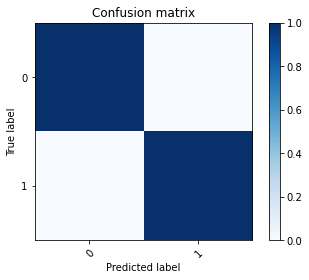

In [83]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

# Normalización de los datos

In [ ]:
scaler = preprocessing.StandardScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.MinMaxScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.RobustScaler()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.PowerTransformer()
summary_1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))